# electricity data analysis

## Summary

* dataset is downloaded from https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014
* dataset contains
   * 370 series (each series represents one house, e.g. MT-001, ...) 
   * each time series contains data from 2011-2014, sampled every 15mins.
   * needs to resampled to 1 hour as paper. 
* according to paper, 
   * training time steps are 25,968
   * test time steps = 24 x 7 = 168
   * train+test = 26136 data points, same as Ymat shape
* Ymat shape is (370,26136) series
* from raw data resample there should be 

## analyze DeepGlo input

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [80]:
Ymat = np.load("./datasets/electricity.npy")

In [100]:
Ymat.shape

(370, 26136)

## preprocessing borrowed from deepAR implementations

### utility

In [74]:
from scipy import stats
from tqdm import trange
import os
import random

In [31]:
def gen_covariates(times, num_covariates):
    covariates = np.zeros((times.shape[0], num_covariates))
    for i, input_time in enumerate(times):
        covariates[i, 1] = input_time.weekday()
        covariates[i, 2] = input_time.hour
        covariates[i, 3] = input_time.month
    for i in range(1,num_covariates):
        covariates[:,i] = stats.zscore(covariates[:,i])
    return covariates[:, :num_covariates]

In [57]:
def prep_data(data, covariates, data_start, total_time, num_series,train = True, save_path='./datasets/',save_name = 'elect'):
    #print("train: ", train)
    time_len = data.shape[0]
    #print("time_len: ", time_len)
    input_size = window_size-stride_size
    windows_per_series = np.full((num_series), (time_len-input_size) // stride_size)
    #print("windows pre: ", windows_per_series.shape)
    if train: windows_per_series -= (data_start+stride_size-1) // stride_size
    #print("data_start: ", data_start.shape)
    #print(data_start)
    #print("windows: ", windows_per_series.shape)
    #print(windows_per_series)
    total_windows = np.sum(windows_per_series)
    x_input = np.zeros((total_windows, window_size, 1 + num_covariates + 1), dtype='float32')
    label = np.zeros((total_windows, window_size), dtype='float32')
    v_input = np.zeros((total_windows, 2), dtype='float32')
    #cov = 3: ground truth + age + day_of_week + hour_of_day + num_series
    #cov = 4: ground truth + age + day_of_week + hour_of_day + month_of_year + num_series
    count = 0
    if not train:
        covariates = covariates[-time_len:]
    for series in trange(num_series):
        cov_age = stats.zscore(np.arange(total_time-data_start[series]))
        if train:
            covariates[data_start[series]:time_len, 0] = cov_age[:time_len-data_start[series]]
        else:
            covariates[:, 0] = cov_age[-time_len:]
        for i in range(windows_per_series[series]):
            if train:
                window_start = stride_size*i+data_start[series]
            else:
                window_start = stride_size*i
            window_end = window_start+window_size
            '''
            print("x: ", x_input[count, 1:, 0].shape)
            print("window start: ", window_start)
            print("window end: ", window_end)
            print("data: ", data.shape)
            print("d: ", data[window_start:window_end-1, series].shape)
            '''
            x_input[count, 1:, 0] = data[window_start:window_end-1, series]
            x_input[count, :, 1:1+num_covariates] = covariates[window_start:window_end, :]
            x_input[count, :, -1] = series
            label[count, :] = data[window_start:window_end, series]
            nonzero_sum = (x_input[count, 1:input_size, 0]!=0).sum()
            if nonzero_sum == 0:
                v_input[count, 0] = 0
            else:
                v_input[count, 0] = np.true_divide(x_input[count, 1:input_size, 0].sum(),nonzero_sum)+1
                x_input[count, :, 0] = x_input[count, :, 0]/v_input[count, 0]
                if train:
                    label[count, :] = label[count, :]/v_input[count, 0]
            count += 1
    prefix = os.path.join(save_path, 'train_' if train else 'test_')
    np.save(prefix+'data_'+save_name, x_input)
    np.save(prefix+'v_'+save_name, v_input)
    np.save(prefix+'label_'+save_name, label)

### load raw data

* original data is sampled every 15mins

In [15]:
raw_data = pd.read_csv('datasets/LD2011_2014.txt', sep=";", index_col=0, parse_dates=True, decimal=',')

In [4]:
raw_data

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:45:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 23:00:00,2.538071,22.048364,1.737619,150.406504,85.365854,303.571429,11.305822,282.828283,68.181818,72.043011,...,276.945039,28200.0,1616.033755,1363.636364,29.986962,5.851375,697.102722,176.961603,651.026393,7621.621622
2014-12-31 23:15:00,2.538071,21.337127,1.737619,166.666667,81.707317,324.404762,11.305822,252.525253,64.685315,72.043011,...,279.800143,28300.0,1569.620253,1340.909091,29.986962,9.947338,671.641791,168.614357,669.354839,6702.702703
2014-12-31 23:30:00,2.538071,20.625889,1.737619,162.601626,82.926829,318.452381,10.175240,242.424242,61.188811,74.193548,...,284.796574,27800.0,1556.962025,1318.181818,27.379400,9.362200,670.763828,153.589316,670.087977,6864.864865
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.175240,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541


### resample to 1H freq and fill na

In [16]:
window_size = 192
stride_size = 24
num_covariates = 4
train_start = '2011-01-01 00:00:00'
train_end = '2014-08-31 23:00:00'
test_start = '2014-08-25 00:00:00' #need additional 7 days as given info
test_end = '2014-09-07 23:00:00'
pred_days = 7
given_days = 7

In [18]:
df = raw_data.resample('1H',label = 'left',closed = 'right').sum()[train_start:test_end]
df.fillna(0, inplace=True)

In [79]:
df

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 04:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-09-07 19:00:00,36.802030,142.958748,7.819288,534.552846,123.170732,550.595238,13.566987,1033.670034,183.566434,115.053763,...,2403.283369,483100.0,21299.578059,31545.454545,810.951760,40.959626,2026.338894,208.681135,3036.656891,82108.108108
2014-09-07 20:00:00,13.959391,135.846373,6.950478,607.723577,163.414634,723.214286,14.697569,1245.791246,314.685315,181.720430,...,2339.043540,480900.0,19628.691983,32318.181818,808.344198,33.937975,1993.854258,215.358932,2973.607038,78486.486486
2014-09-07 21:00:00,46.954315,130.867710,6.950478,603.658537,195.121951,767.857143,19.785189,1205.387205,288.461538,207.526882,...,1985.010707,467800.0,14637.130802,32113.636364,804.432855,23.405500,2139.596137,178.631052,2969.941349,80378.378378
2014-09-07 22:00:00,65.989848,128.733997,6.950478,542.682927,209.756098,702.380952,18.089316,1084.175084,208.041958,203.225806,...,1324.768023,411700.0,11687.763713,23500.000000,615.384615,37.448800,2656.716418,186.978297,2913.489736,79297.297297


* 370 houses, each column is one house
* time index from 2011-01-01 to 2014-09-07

### plots

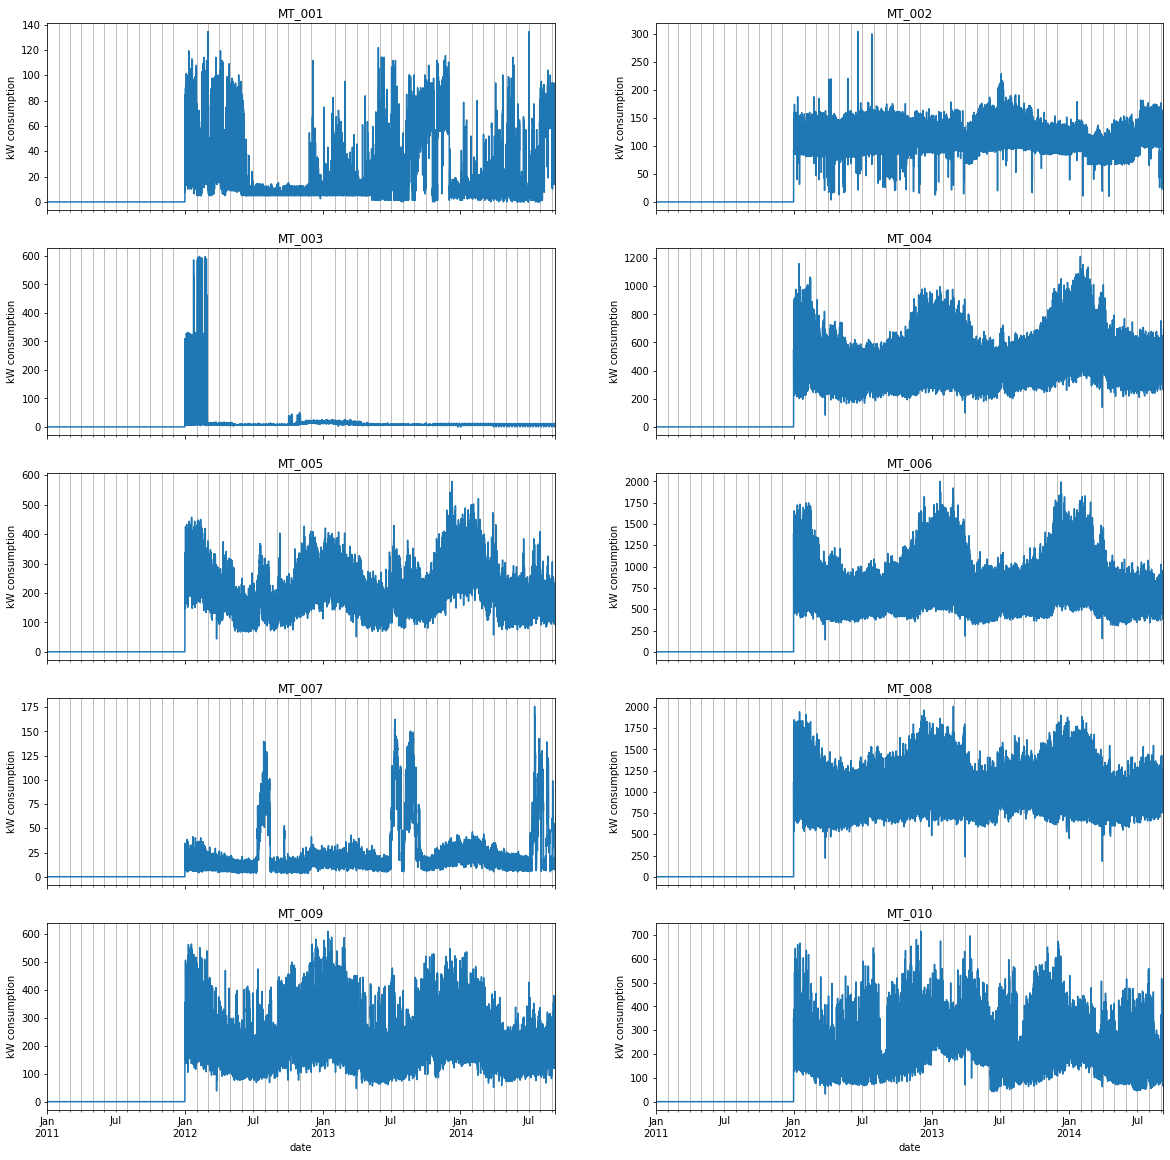

In [116]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20),sharex=True)
axx = axs.ravel()
i = 0
for idx in range(10):
#for idx in random.sample(range(df.shape[1]),k=10):
    #series = df.iloc[:,idx].loc["2014-01-01":"2014-01-20"]
    series = df.iloc[:,idx]
    series.plot(ax=axx[i])
    axx[i].set_title(series.name)
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("kW consumption")   
    axx[i].grid(which='minor', axis='x')
    i += 1

### generate covariates

* covariates can be interpreted as extra features
* in gen_covariates, first add below 3 features and then change it to zscore
  * weekday
  * month
  * hour
* it seems the first column of covariates is not used (always 0)
* In current run_electricity script seems no covariates is used, we can later add them if needed 

In [33]:
covariates = gen_covariates(df[train_start:test_end].index, num_covariates)

In [34]:
print(covariates.shape)
covariates

(32304, 4)


array([[ 0.        ,  0.99768121, -1.66132477, -1.54157082],
       [ 0.        ,  0.99768121, -1.51686175, -1.54157082],
       [ 0.        ,  0.99768121, -1.37239873, -1.54157082],
       ...,
       [ 0.        ,  1.49745006,  1.37239873,  0.84172201],
       [ 0.        ,  1.49745006,  1.51686175,  0.84172201],
       [ 0.        ,  1.49745006,  1.66132477,  0.84172201]])

### check zero values

In [36]:
train_data = df[train_start:train_end].values
test_data = df[test_start:test_end].values

In [38]:
train_data.shape, test_data.shape

((32136, 370), (336, 370))

* seems there's a lot of zero values 

In [42]:
data_start = (train_data!=0).argmax(axis=0) #find first nonzero value in each time series

In [44]:
print(data_start.shape)
data_start

(370,)


array([ 8760,  8760,  8760,  8760,  8760,  8760,  8760,  8760,  8760,
        8760,  8760, 23318,  8760,  8760, 21254,  8760,  8760,  8760,
        8760,  8760,  8760,  8760,  8760, 10907,  8760,  8760,  8760,
        8760,  8760, 20630,  8760, 16454, 13430,  8760,  8760,  8760,
        8760,  8760, 24156,  8760, 23679,  8760,  8760,  8760,  8760,
        8760,  8760,  8760,  8760,  8760,  8760,  8760,  8760,  8760,
        8760,  8760,  8760,  8760,  8760,  8760,  8760,  8760,  8760,
        8760,  8760,  8760,  8760,  8760,  8760,  8760,  8760,  8760,
        8760,  8760,  8760,  8760,  8760,  8760,  8760,  8760,  8760,
        8760,  8760,  8760,  8760,  8760,  8760,  8760,  8760,  8760,
        8760, 18273,  8760,  8760,  8760,  8760,  8760,  8760,  8760,
        8760,  8760,  8760,  8760,  8760,  8760, 26616, 26616, 26616,
       27456, 26616, 26616, 27312, 26616,  8760, 26616, 27456, 26616,
        8760,  8760, 26616, 26616, 26616,  8760,     0,  8760,  8760,
       13128,  8760,

In [58]:
total_time = df.shape[0] #32304
num_series = df.shape[1] #370
prep_data(train_data, covariates, data_start, total_time, num_series )
prep_data(test_data, covariates, data_start, total_time, num_series,train=False)

100%|██████████| 370/370 [00:00<00:00, 859.37it/s]


## compare between DeepGLO input and raw resampled

In [82]:
processed_df_from_raw = df

In [83]:
processed_df_from_raw

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 04:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-09-07 19:00:00,36.802030,142.958748,7.819288,534.552846,123.170732,550.595238,13.566987,1033.670034,183.566434,115.053763,...,2403.283369,483100.0,21299.578059,31545.454545,810.951760,40.959626,2026.338894,208.681135,3036.656891,82108.108108
2014-09-07 20:00:00,13.959391,135.846373,6.950478,607.723577,163.414634,723.214286,14.697569,1245.791246,314.685315,181.720430,...,2339.043540,480900.0,19628.691983,32318.181818,808.344198,33.937975,1993.854258,215.358932,2973.607038,78486.486486
2014-09-07 21:00:00,46.954315,130.867710,6.950478,603.658537,195.121951,767.857143,19.785189,1205.387205,288.461538,207.526882,...,1985.010707,467800.0,14637.130802,32113.636364,804.432855,23.405500,2139.596137,178.631052,2969.941349,80378.378378
2014-09-07 22:00:00,65.989848,128.733997,6.950478,542.682927,209.756098,702.380952,18.089316,1084.175084,208.041958,203.225806,...,1324.768023,411700.0,11687.763713,23500.000000,615.384615,37.448800,2656.716418,186.978297,2913.489736,79297.297297


In [84]:
processed_deepglo_input = Ymat

In [85]:
processed_deepglo_input.shape

(370, 26136)

In [91]:
processed_df_from_raw.iloc[-10:,0]

2014-09-07 14:00:00    63.451777
2014-09-07 15:00:00    60.913706
2014-09-07 16:00:00    58.375635
2014-09-07 17:00:00    62.182741
2014-09-07 18:00:00    77.411168
2014-09-07 19:00:00    36.802030
2014-09-07 20:00:00    13.959391
2014-09-07 21:00:00    46.954315
2014-09-07 22:00:00    65.989848
2014-09-07 23:00:00    65.989848
Freq: H, Name: MT_001, dtype: float64

In [95]:
processed_deepglo_input[0]

array([16.497 , 19.036 , 16.497 , ...,  7.6142,  7.6142,  7.6142])

In [88]:
processed_deepglo_input[0].shape

(26136,)

In [97]:
processed_deepglo_input

array([[1.6497e+01, 1.9036e+01, 1.6497e+01, ..., 7.6142e+00, 7.6142e+00,
        7.6142e+00],
       [9.1038e+01, 9.2461e+01, 9.1750e+01, ..., 8.8193e+01, 8.8193e+01,
        8.2504e+01],
       [3.0930e+02, 3.0930e+02, 3.0930e+02, ..., 6.9505e+00, 6.9505e+00,
        6.9505e+00],
       ...,
       [2.4374e+02, 2.4541e+02, 2.0367e+02, ..., 7.0785e+02, 6.7279e+02,
        4.9082e+02],
       [2.8541e+03, 2.8233e+03, 2.7566e+03, ..., 2.7808e+03, 2.7903e+03,
        2.7669e+03],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 2.7946e+04, 2.7189e+04,
        2.7189e+04]])

### plot

In [228]:
def plot_single(seris, ax, title, **kwargs):
    ax.plot(seris,**kwargs)
    #series.plot(ax=axx[i])
    ax.set_title(title)
    #ax.set_xlabel("date")    
    ax.set_ylabel("kW consumption")   
    ax.grid(which='minor', axis='x')

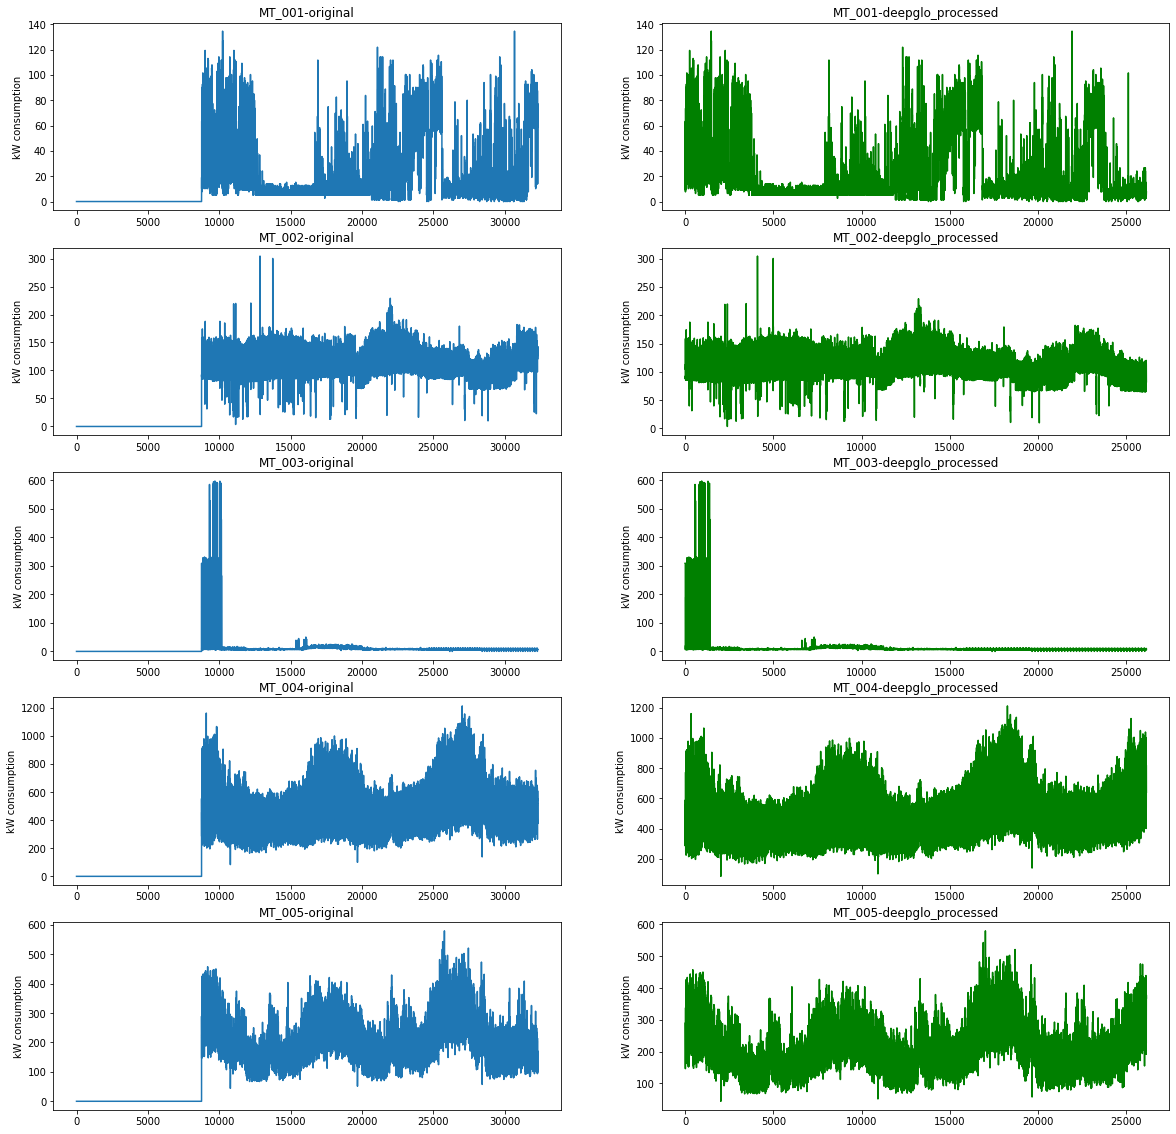

In [229]:
num_samples = 5 
fig, axs = plt.subplots(num_samples, 2, figsize=(20, 20),sharex=False)
axx = axs.ravel()

for i in range(0,num_samples):
    series_id = i
    figure_id = i*2
    #series = df.iloc[:,idx].loc["2014-01-01":"2014-01-20"]
    series = df.iloc[:,series_id]
    plot_single(series.values, axx[figure_id], title=series.name+"-"+"original")
    series_processed = Ymat[series_id]
    plot_single(series_processed, axx[figure_id+1], title=series.name+"-"+"deepglo_processed", color='g')
    

* seems the preprocess just select part of non zero data without any preprocessing.
* amazon seems to have used more electricity data than original. 

In [181]:
test_0 = df.iloc[:,0]
range_start = (test_0!=0).argmax(axis=0) 
non_zero_test_0 = test_0[range_start:].values
non_zero_test_0

array([16.49746193, 19.03553299, 16.49746193, ..., 46.95431472,
       65.98984772, 65.98984772])

In [206]:
range_length=non_zero_test_0.shape[0]

In [207]:
Ymat[0,:range_length]

array([16.497, 19.036, 16.497, ..., 46.954, 65.99 , 65.99 ])

In [209]:
np.abs(non_zero_test_0 - Ymat[0,:range_length]).mean()

0.00016434603058546293

### try process and plot again

In [188]:
select_start = range_start
select_end = range_end

In [210]:
def process_Ymat(Ymat,range_start,range_length):
    return Ymat[:,:range_length]

In [212]:
def process_original(df,range_start, range_length):
    return df.iloc[range_start:range_start+range_length,:].values.swapaxes(0,1)

In [213]:
Ymat_processed = process_Ymat(Ymat,select_start,select_end)
Orignal_processed = process_original(df,select_start,select_end)
Ymat_processed.shape,Orignal_processed.shape

((370, 23544), (370, 23544))

In [215]:
Ymat_processed[-1], Orignal_processed[-1]

(array([    0.,     0.,     0., ..., 80378., 79297., 82541.]),
 array([    0.        ,     0.        ,     0.        , ...,
        80378.37837838, 79297.2972973 , 82540.54054054]))

In [220]:
#echeck difference between two mats
np.mean(np.abs(Ymat_processed- Orignal_processed),axis=1)

array([1.64346031e-04, 1.77786512e-03, 1.32874520e-04, 2.56651169e-03,
       2.44017636e-03, 5.50434445e-03, 3.39037643e-04, 1.43895576e-02,
       2.43972214e-03, 2.38362672e-03, 2.37558780e-03, 1.19452216e-03,
       2.50186525e-03, 2.34305915e-03, 8.81284699e-04, 2.00762601e-03,
       2.49368547e-03, 1.30719873e-02, 2.49381848e-04, 2.38689712e-03,
       3.76251305e-03, 1.29176468e-03, 2.51298988e-04, 1.63859839e-03,
       9.08596273e-03, 7.28893467e-04, 6.96229063e-04, 2.50602791e-03,
       2.43430252e-03, 1.18820572e-03, 2.49560062e-03, 1.10346240e-03,
       1.86866518e-03, 2.74992787e-04, 2.50298982e-03, 1.32235612e-03,
       2.54245444e-03, 2.49908626e-03, 8.15894970e-04, 2.47959490e-03,
       9.05082939e-04, 2.42090756e-03, 2.48761700e-02, 1.65288704e-03,
       2.42716672e-03, 2.71155509e-03, 1.58449236e-03, 3.24337989e-04,
       2.47766993e-02, 3.94073095e-03, 2.50381154e-03, 2.27002712e-03,
       2.49100841e-03, 2.51184262e-03, 1.12146937e-03, 2.34063459e-03,
      

In [265]:
def plot_compare(num_samples, original_processed, ymat_processed, show_part=None):
    fig, axs = plt.subplots(num_samples,figsize=(20, 20),sharex=False)
    axx = axs.ravel()
    columns = df.columns
    for i in range(0,num_samples):
        series_id = i
        figure_id = i
        #series = df.iloc[:,idx].loc["2014-01-01":"2014-01-20"]
        #series = Ymat_processed[series_id]
        if show_part is not None:
            original_processed = original_processed[:,show_part[0]:show_part[1]]
            ymat_processed = ymat_processed[:,show_part[0]:show_part[1]]
            print(original_processed.shape,ymat_processed.shape)
        plot_single(original_processed[series_id], axx[figure_id], title=columns[series_id]+"-"+"original")
        plot_single(ymat_processed[series_id], axx[figure_id], title=columns[series_id]+"-"+"deepglo_input",
                    color='r',linestyle='dotted')

(370, 10) (370, 10)
(370, 10) (370, 10)
(370, 10) (370, 10)
(370, 10) (370, 10)
(370, 10) (370, 10)


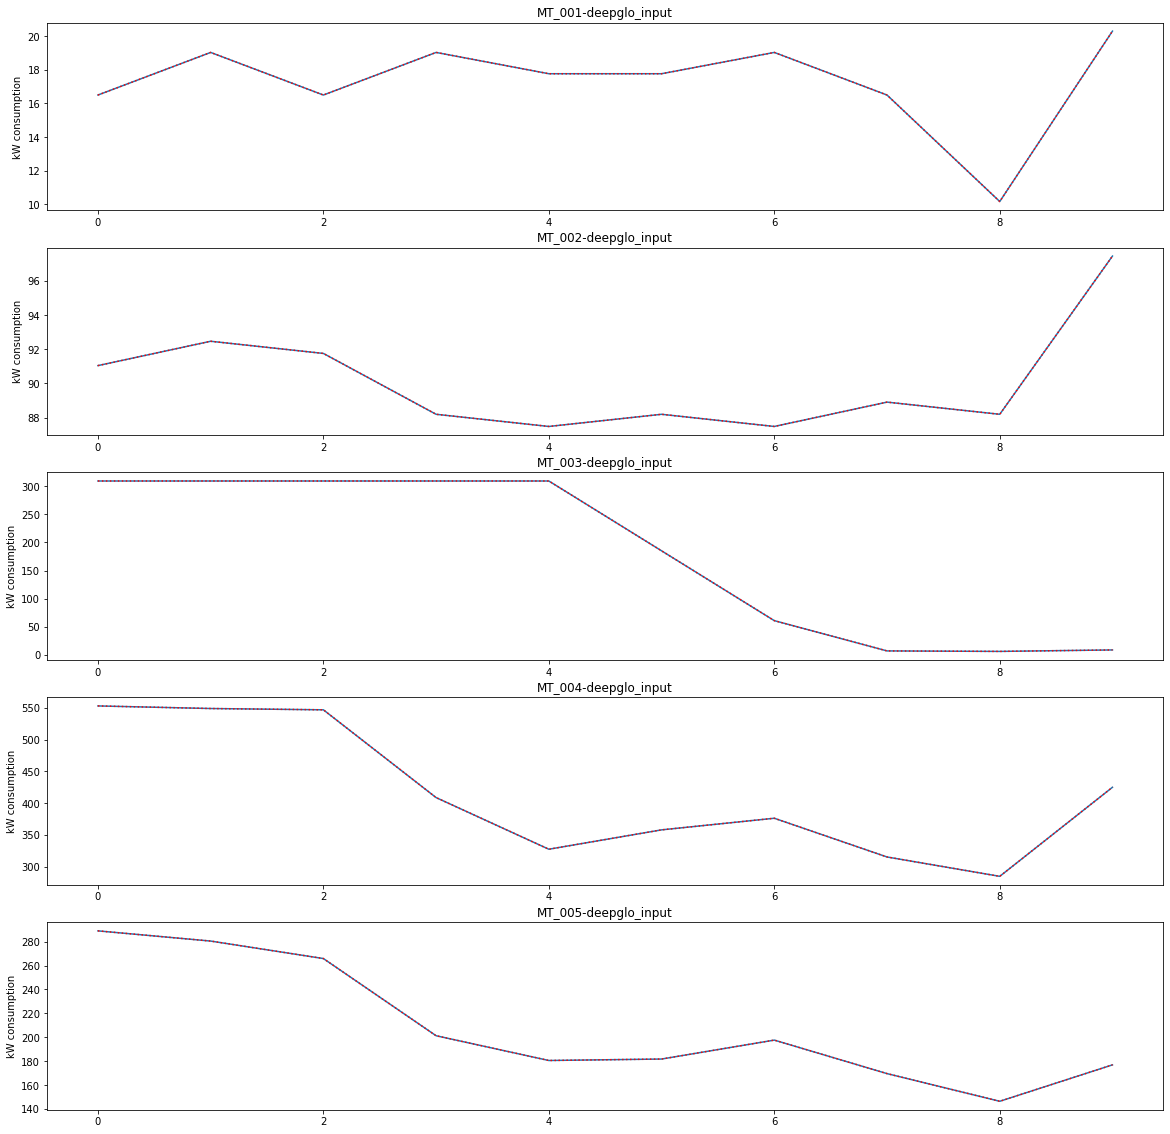

In [266]:
plot_compare(5,Orignal_processed,Ymat_processed,show_part=(0,10))